In [1]:
import os

import cv2
import dlib
import time
import glob
import random
import openface
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from skimage import io
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import callbacks
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


### Face Landmarks

In [2]:
# Docs:
# - http://openface-api.readthedocs.io/en/latest/index.html
# - http://dlib.net/python/index.html

# Pre-trained face detection model
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2"
predictor_model = 'Resources/shape_predictor_68_face_landmarks.dat'
embeddings = 'Resources/dlib_face_recognition_resnet_model_v1.dat'

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
face_aligner = openface.AlignDlib(predictor_model)
face_descriptor = dlib.face_recognition_model_v1(embeddings)

### Loading and Pre-Processing Data

In [3]:
path = 'Data/yalefaces'

In [4]:
labels = []
images = []
size = 50

for p in os.listdir(path):
    images.append(io.imread(os.path.join(path, p), as_grey=True))
    labels.append(int(p.split('.')[0].replace('subject', ''))-1) # original from 1 to 15
    
n_targets = len(set(labels))

In [5]:
print('Number of unique labels:', len(set(labels)))
print('Number of images:', len(labels))

Number of unique labels: 15
Number of images: 165


In [6]:
def get_face(image, size):
    # Run the HOG face detector on the image data
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detected_faces = face_detector(image, 1)
    # print("Found {} face(s) in the image file {}".format(len(detected_faces), labels[0]))
    # Loop through each face we found in the image
    for i, face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates 
        # of the top, left, right and bottom edges
        # print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom())) 
        # Use openface to calculate and perform the face alignment
        return face_aligner.align(size, image, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
    return None

In [7]:
# Discarding images where faces weren't found
X = [] # faces
y = [] # labels
b = [] # bad data
for i, image in enumerate(images):
    face = get_face(image, size)
    if face is None:
        b.append(i)
    else:
        X.append(face)
        y.append(labels[i])

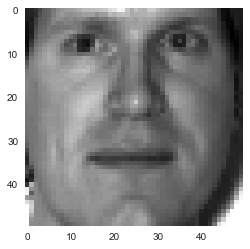

In [8]:
plt.figure()
plt.grid(False)
plt.imshow(X[0], cmap='gray')

In [9]:
X = np.array(X)
y = np.array(y)

print('Bad images:', b)
print('Remanescent images:', len(X))
print(X.shape)
print(y.shape)

Bad images: [6, 50, 116]
Remanescent images: 162
(162, 50, 50)
(162,)


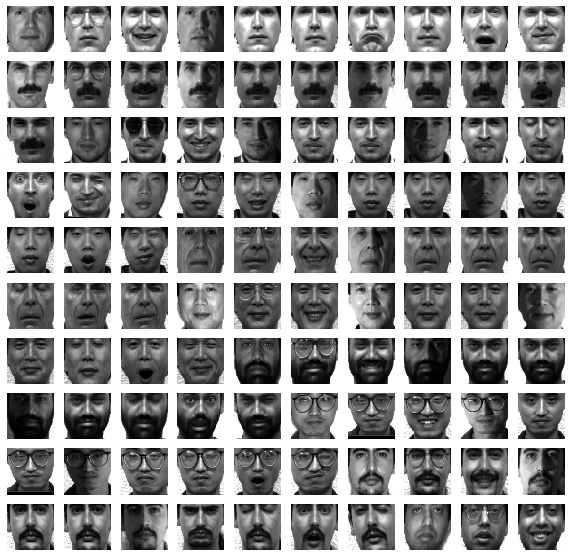

In [10]:
f, axes = plt.subplots(10, 10, figsize=(10, 10))
for index, image in enumerate(X[:100]):
    axes[int(index/10)][int(index%10)].imshow(image.reshape(size, size), cmap='gray', interpolation='nearest')
    axes[int(index/10)][int(index%10)].set_xticks(np.array([]))
    axes[int(index/10)][int(index%10)].set_yticks(np.array([]))

## First Approach
---

1. Crop the faces in a fixed size
2. Align them using *openface*
3. Get 128 embeddings using *dlib*
4. GridSearch with SVM to choose the best parameters
5. Train the model obtained in the previous step
4. Predict

- Face #164 found at Left: 124 Top: 96 Right: 253 Bottom: 225


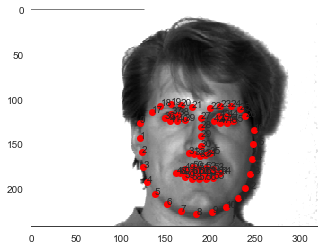

In [11]:
face_rect = face_detector(images[0], 1)[0]
print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom())) 
pose_landmarks = face_pose_predictor(images[0], face_rect).parts()

plt.figure()
plt.grid(False)
plt.imshow(images[0], cmap='gray')
for i, p in enumerate(pose_landmarks):
    plt.plot(p.x, p.y, 'ro')
    plt.text(p.x, p.y, i)

In [12]:
def get_embeddings(image):
    face_rect = dlib.rectangle(left=0, top=0, right=size, bottom=size)
    # Get the landmarks/parts for the face in box face_rect.
    shape = face_pose_predictor(image, face_rect)
    # Compute the 128D vector that describes the face in img identified by
    # shape.  In general, if two face descriptor vectors have a Euclidean
    # distance between them less than 0.6 then they are from the same
    # person, otherwise they are from different people.  He we just print
    # the vector to the screen.
    return face_descriptor.compute_face_descriptor(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), shape, 1)

In [13]:
l = []
for x in X:
    l.append(get_embeddings(x))

In [14]:
l = np.array(l)

In [15]:
print ('Training array shape:', l.shape)

Training array shape: (162, 128)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(l, y, random_state=0)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(121, 128)
(121,)
(41, 128)
(41,)


In [18]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype('float32').reshape(X_train.shape[0], -1))
X_test  = scaler.transform(X_test.astype('float32').reshape(X_test.shape[0], -1))

### Grid Search

In [19]:
from sklearn import svm

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy
Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      1.00      1.00         2
          2       1.00      1.00      1.00         2
          3       1.00      0.67      0.80         3
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         6
          6       1.00      1.00      1.00         2
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00         4
         12       1.00      1.00      1.00         5
         13       0.80      1.00      0.89 

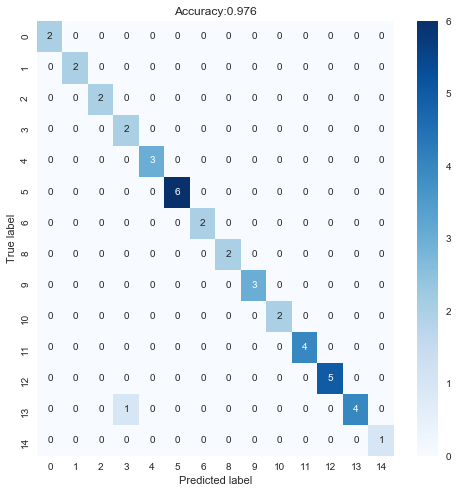

In [20]:
clf = svm.SVC(C=100, gamma=0.001, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cf = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cf, index=set(y_test), columns=set(y_test))

plt.figure(figsize = (8, 8))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_pred, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Second Approach
---

1. Crop the faces in a fixed size
2. Align them using *openface*
3. Train a CNN
4. Predict

In [21]:
print ('Training array shape:', np.array(X).shape)

Training array shape: (162, 50, 50)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(121, 50, 50)
(121,)
(41, 50, 50)
(41,)


In [24]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype('float32').reshape(X_train.shape[0], size*size))
X_test  = scaler.transform(X_test.astype('float32').reshape(X_test.shape[0], size*size))

In [25]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [26]:
X_train = X_train.astype('float32').reshape(X_train.shape[0], size, size, 1)
X_test  = X_test.astype('float32').reshape(X_test.shape[0], size, size, 1)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(121, 50, 50, 1)
(121, 15)
(41, 50, 50, 1)
(41, 15)


### Model

In [28]:
def plot_history(history, x, y):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(x, y))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(x, y))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [29]:
input_shape = (size, size, 1)

def create_model(init='he_normal', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(6, 6), activation='relu', input_shape=input_shape, padding='same', name='b1_conv'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='b1_poll'))
    model.add(Conv2D(128, kernel_size=(6, 6), activation='relu', padding='same', name='b2_conv'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='b2_pool'))
    model.add(Conv2D(256, kernel_size=(6, 6), activation='relu', padding='same', name='b3_conv'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='b3_pool'))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation='relu', name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(n_targets, activation='softmax', name='prediction'))
    model.compile(optimizer=optim, loss='categorical_crossentropy',  metrics=['accuracy'])
    
    return model

In [30]:
def generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, size, size, 1))
    batch_labels = np.zeros((batch_size, n_targets))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features[i] = features[index]
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

### Grid Seach

In [31]:
rms  = optimizers.RMSprop(lr=0.0005)
adag = optimizers.Adagrad(lr=0.0005)
adam = optimizers.Adam(lr=0.0005)
adamm = optimizers.Adamax(lr=0.0005)
nadam = optimizers.Nadam(lr=0.0005)


optim = [rms, adag, adam, adamm, nadam]

for o in optim:
    model = create_model(optim=o)
    model.fit_generator(generator(X_train, y_train, batch_size=32),
                        steps_per_epoch=X_train.shape[0] // 32,
                        epochs=100, verbose=0, validation_data=(X_test, y_test))
    scores = model.model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%% Model %s" % (model.model.metrics_names[1], scores[1]*100, o))

acc: 80.49% Model <keras.optimizers.RMSprop object at 0x000002379343C0B8>
acc: 78.05% Model <keras.optimizers.Adagrad object at 0x00000237933BCE48>
acc: 75.61% Model <keras.optimizers.Adam object at 0x00000237933BC4A8>
acc: 75.61% Model <keras.optimizers.Adamax object at 0x000002379343CEB8>
acc: 85.37% Model <keras.optimizers.Nadam object at 0x0000023792037E80>


In [32]:
K.clear_session()

In [33]:
batch_size = 32
start_time = time.time()

model = create_model(optim=optimizers.Nadam(lr=0.0005))
hist = model.fit_generator(generator(X_train, y_train, batch_size=batch_size),
                           steps_per_epoch=X_train.shape[0] // batch_size,
                           epochs=100, verbose=0, validation_data=(X_test, y_test))


print("--- %s seconds ---" % (time.time() - start_time))

--- 101.78679490089417 seconds ---


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


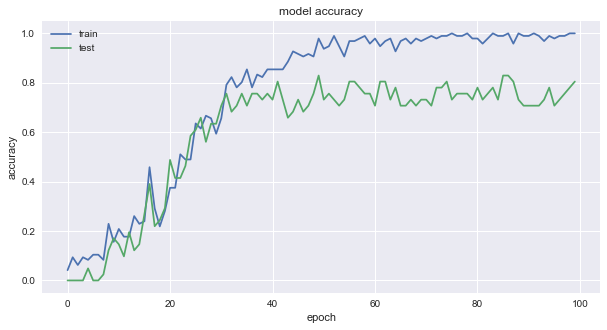

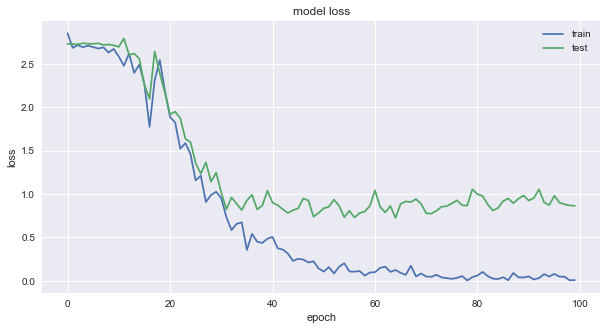

In [34]:
plot_history(hist, 10, 5)

In [35]:
scores = model.model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.model.metrics_names[1], scores[1]*100))

acc: 80.49%


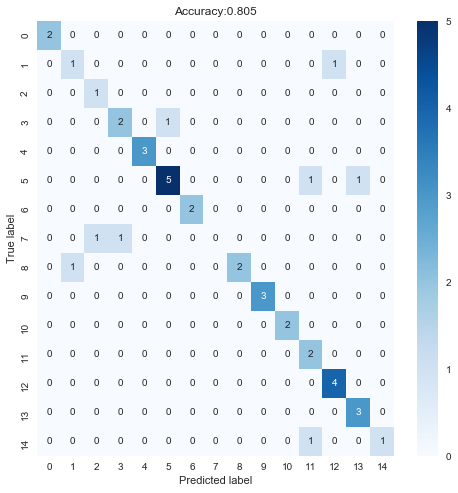

In [36]:
y_pred = model.model.predict(X_test)
cf = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

df_cm = pd.DataFrame(cf, index=set(labels), columns=set(labels))

plt.figure(figsize = (8, 8))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [37]:
ground_truth = np.argmax(y_test, axis=1)
prediction = np.argmax(y_pred, axis=1)
misclassified = np.where(ground_truth != prediction)
print('Misclassified:', misclassified[0])
print('Ground Truth: ', ground_truth[misclassified[0]])
print('Prediction:   ', prediction[misclassified[0]])

Misclassified: [ 6 14 21 25 31 33 36 37]
Ground Truth:  [11 11  5  3  2 13 12  1]
Prediction:    [14  5  3  7  7  5  1  8]


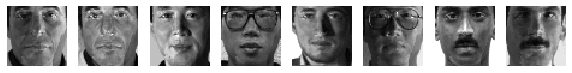

In [38]:
f, axes = plt.subplots(1, len(misclassified[0]), figsize=(10, 10))
for i, m in enumerate(misclassified[0]):
    axes[i].imshow(X_test[m, :, :].reshape(size, size), cmap='gray', interpolation='nearest')
    axes[i].set_xticks(np.array([]))
    axes[i].set_yticks(np.array([]))

In [39]:
%%script false
optim = optimizers.Adam(lr=0.0005)
model = KerasClassifier(build_fn=create_model, optim=optim)
hist = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0, validation_data=(X_test, y_test))

Couldn't find program: 'false'


In [40]:
%%script false
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
 
# grid initial weight, batch size and optimizer
sgd  = optimizers.SGD(lr=0.0005)
rms  = optimizers.RMSprop(lr=0.0005)
adag = optimizers.Adagrad(lr=0.0005)
adad = optimizers.Adadelta(lr=0.0005)
adam = optimizers.Adam(lr=0.0005)
adamm = optimizers.Adamax(lr=0.0005)
nadam = optimizers.Nadam(lr=0.0005)

optim = [sgd, rms, adag, adad, adam, adamm, nadam]
init = ['glorot_uniform', 'normal', 'uniform', 'he_normal']
batches = [32, 64, 128]
param_grid = dict(optim=optim, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Couldn't find program: 'false'


In [41]:
# TensorBoard callback 
# model = KerasClassifier(build_fn=create_model, verbose=0)
# tbCallBack = callbacks.TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)
# hist = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0, validation_data=(X_test, y_test), callbacks=[tbCallBack])